<h1 style="text-align: center;"><a href="https://www.whatwouldaithink.com">WhatWouldAiThink.com</a></h1>


<h3 style="text-align: center;">Classification of Cats and Dogs</h3>

<h3 style="text-align: center;">April 2024</h3>

<h3 style="text-align: center;">This notebook is made for the analysis of cats and dogs published on:
<a href="https://www.whatwouldaithink.com">whatwouldaithink.com</a></h3>
<h4 style="text-align: center;">Copyright © 2022-Present whatwouldaithink.com - All Rights Reserved</h4>

<h1 style="text-align: center;"> Fine-tune a pretrained DenseNet201 model </h1>

In [1]:
# import basics
import os
from pathlib import Path
import time

# import torch
import torch
from torchvision.models import densenet201, DenseNet201_Weights
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
from random import randrange

# custom modules
import sys
sys.path.append('..')
from vision.Utils import info
from vision.Definitions import *
from vision.Utils import printNumOfLearnableWeights, findOptimumBatchSize
from vision.Utils import readDataToDataFrame, createDirectories
from vision.TransformImages import TransformImages
from vision.Data import Data
from vision.Models import CNN
from vision.ValidationTools import MyValidator, ValidatePretrainedModel
from vision.TrainModels import TrainingManager
# MIN_SIZE_IMAGE is 224, defined in vision.Definitions

pathDataSet = "datasets"
pathDataSet224x224 = f"datasets{MIN_SIZE_IMAGE[0]}x{MIN_SIZE_IMAGE[1]}"

<h1>1. Check and preprocess the data</h1>

### Create the DataFrames

In [2]:
# "training_set" and "test_set" are from https://www.kaggle.com/datasets/charmz/cats-and-dogs
df_train = readDataToDataFrame(os.path.join(pathDataSet, "training_set"))
df_test = readDataToDataFrame(os.path.join(pathDataSet, "test_set"))

# "validate_set" and "validate_set_cropped" are from https://github.com/WhatWouldAiThink/About_Cats_in_Montenegro
df_validate = readDataToDataFrame(os.path.join(pathDataSet, "validate_set"))
df_validateCropped = readDataToDataFrame(os.path.join(pathDataSet, "validate_set_cropped"))

Reading files from folder: datasets/training_set/cats
Reading files from folder: datasets/training_set/dogs
Reading files from folder: datasets/test_set/cats
Reading files from folder: datasets/test_set/dogs
Reading files from folder: datasets/validate_set/cats
Reading files from folder: datasets/validate_set_cropped/cats


### Create the DataSets

In [3]:
dataSetTrain = Data(df_train)
dataSetTest = Data(df_test)
dataSetValidate = Data(df_validate)
dataSetValidateCropped = Data(df_validateCropped)

### Plot images for all DataSets to get an idea of the data.

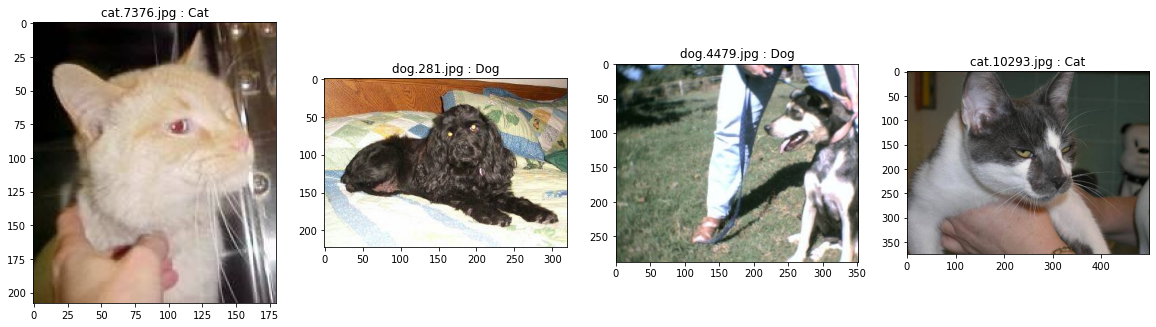

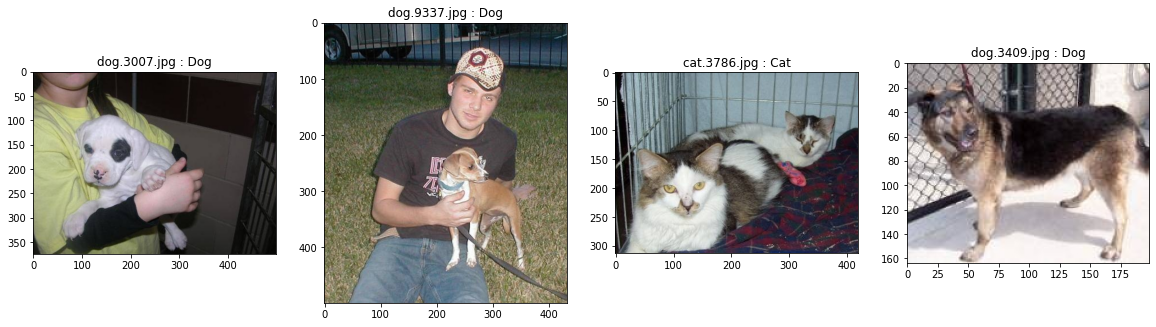

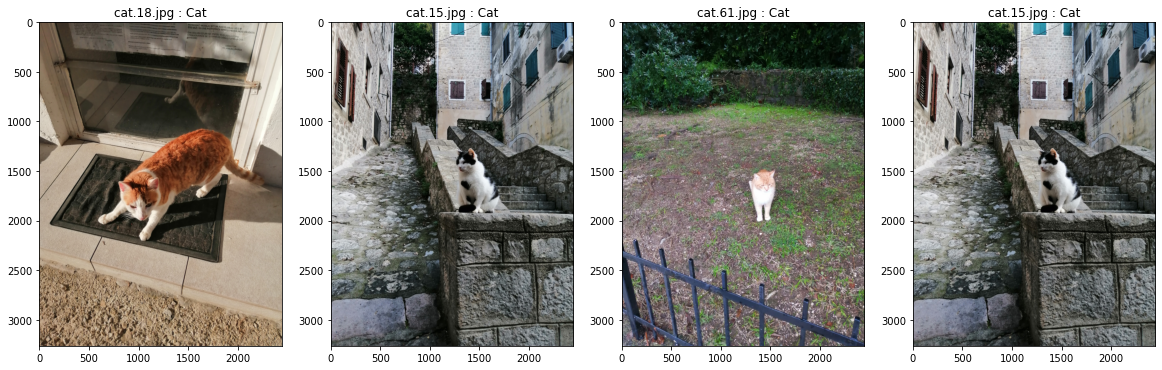

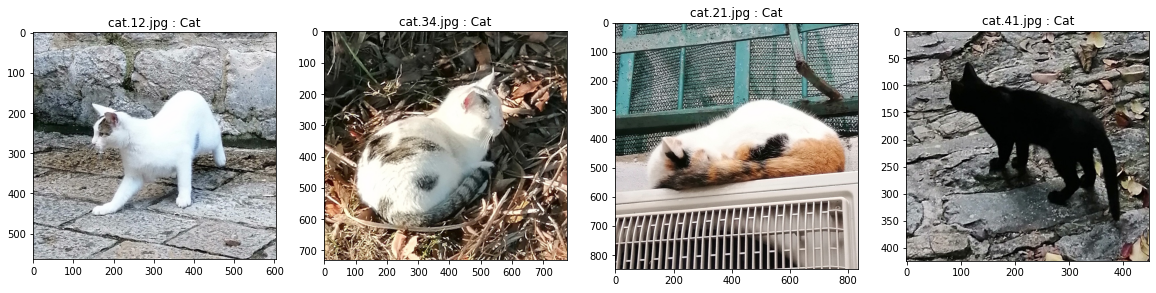

In [4]:
for dataSet in [dataSetTrain, dataSetTest, dataSetValidate, dataSetValidateCropped]:
    rows = dataSet.__len__()
    dataSet.plotImages([randrange(0, rows) for _ in range(4)])

<h1>2. Filter the data for training </h1>

### Create a new directory and resize the images to MIN_SIZE_IMAGE

In [5]:
# create a new directory with subfolders for images with size MIN_SIZE_IMAGE
folders = ["training_set", 
           "test_set", 
           "validate_set", 
           "validate_set_cropped"]
    
# resize the images and save it in the new directory             
if createDirectories(pathDataSet224x224, folders):
    transformer = TransformImages(pathDataSet, pathDataSet224x224, resize=True, size=MIN_SIZE_IMAGE)
    transformer.resize() 

created directory: datasets224x224/training_set/cats
created directory: datasets224x224/training_set/dogs
created directory: datasets224x224/test_set/cats
created directory: datasets224x224/test_set/dogs
created directory: datasets224x224/validate_set/cats
created directory: datasets224x224/validate_set/dogs
created directory: datasets224x224/validate_set_cropped/cats
created directory: datasets224x224/validate_set_cropped/dogs


### Create new DataFrames with equal image size MIN_SIZE_IMAGE

In [6]:
df_train    = readDataToDataFrame(os.path.join(pathDataSet224x224, "training_set"))
df_test     = readDataToDataFrame(os.path.join(pathDataSet224x224, "test_set"))
df_validate = readDataToDataFrame(os.path.join(pathDataSet224x224, "validate_set"))
df_validateCropped = readDataToDataFrame(os.path.join(pathDataSet224x224, "validate_set_cropped"))

Reading files from folder: datasets224x224/training_set/cats
Reading files from folder: datasets224x224/training_set/dogs
Reading files from folder: datasets224x224/test_set/cats
Reading files from folder: datasets224x224/test_set/dogs
Reading files from folder: datasets224x224/validate_set/cats
Reading files from folder: datasets224x224/validate_set_cropped/cats


### Check the new DataFrames and basic statistics. We see that all small images have equal size of 224x224 pixel.

In [7]:
df_train.describe()

,label,width,height
count,17650.000000,17650.0,17650.0
mean,0.499150,224.0,224.0
std,0.500013,0.0,0.0
min,0.000000,224.0,224.0
25%,0.000000,224.0,224.0
50%,0.000000,224.0,224.0
75%,1.000000,224.0,224.0
max,1.000000,224.0,224.0


In [8]:
df_test.describe()

,label,width,height
count,4395.000000,4395.0,4395.0
mean,0.500114,224.0,224.0
std,0.500057,0.0,0.0
min,0.000000,224.0,224.0
25%,0.000000,224.0,224.0
50%,1.000000,224.0,224.0
75%,1.000000,224.0,224.0
max,1.000000,224.0,224.0


In [9]:
df_validate.describe()

,label,width,height
count,61.0,61.0,61.0
mean,1.0,224.0,224.0
std,0.0,0.0,0.0
min,1.0,224.0,224.0
25%,1.0,224.0,224.0
50%,1.0,224.0,224.0
75%,1.0,224.0,224.0
max,1.0,224.0,224.0


In [10]:
df_validateCropped.describe()

,label,width,height
count,61.0,61.0,61.0
mean,1.0,224.0,224.0
std,0.0,0.0,0.0
min,1.0,224.0,224.0
25%,1.0,224.0,224.0
50%,1.0,224.0,224.0
75%,1.0,224.0,224.0
max,1.0,224.0,224.0


### Create new DataSets with equal image size MIN_SIZE_IMAGE

In [11]:
dataSetTrain = Data(df_train)
dataSetTest = Data(df_test)
dataSetValidate = Data(df_validate)
dataSetValidateCropped = Data(df_validateCropped)

### Count the number of cats and dogs in the train and test set. Both set's are almost balanced.

In [12]:
for (df, nameDataFrame) in zip([df_train, df_test], ["train", "test"]):
    for label in [0, 1]:
        print(f"There are {df[df['label'] == label].shape[0]} {labelDic[label]}s in the {nameDataFrame} set.")


There are 8840 Dogs in the train set.
There are 8810 Cats in the train set.
There are 2197 Dogs in the test set.
There are 2198 Cats in the test set.


<h1>3.Fine-tune a DenseNet201 model with color images</h1>

Linear(in_features=1920, out_features=1000, bias=True)

Linear(in_features=1920, out_features=2, bias=True)

Number of trainable weights: 3842
Number of samples for train: 17650
Number of samples for test: 4395
Number of samples for vali: 61
Number of samples for valiCrop: 61

File checkpoint_ColorImagesDenseNet201.pt or checkpoint_ColorImagesDenseNet201_best.pt already exist.
ONLY RESUME TRAINING POSSIBLE!!!.


Loading checkpoint: checkpoint_ColorImagesDenseNet201.pt
checkpoint[epoch]: 5

Loading checkpoint['accuracy_lists']
valiCrop : [0.7704918032786885, 0.7540983606557377, 0.819672131147541, 0.8688524590163934, 0.7540983606557377]
len = 5
train : [0.9691218130311615, 0.9801699716713881, 0.9820963172804532, 0.9787535410764873, 0.9811331444759207]
len = 5
test : [0.9872582480091012, 0.9881683731513083, 0.9883959044368601, 0.986575654152446, 0.9870307167235495]
len = 5
vali : [0.39344262295081966, 0.4426229508196721, 0.6885245901639344, 0.7704918032786885, 0.4098360655737705]
len = 5

Loading checkpoint: checkpoint_ColorImagesDenseNet201_best.pt
max_accuracy is: 0.9883959044368601


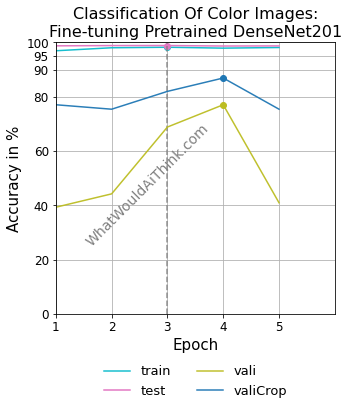

In [13]:
# define the model
model = densenet201(weights=DenseNet201_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False  


display(model.classifier)
# Redefine the full connected layer 
# and set the out_features=2
num_ftrs = model.classifier.in_features
model.classifier = torch.nn.Linear(num_ftrs, 2)
display(model.classifier)

# print number of learnable weights
printNumOfLearnableWeights(model)

# Train the model
checkpoint="ColorImagesDenseNet201"
tm = TrainingManager(lr=0.001, model=model, nameCheckpoint=checkpoint, 
                     batchSize=32, criterion="CE", 
                     datasets={"train": dataSetTrain, 
                      "test": dataSetTest,
                      "vali": dataSetValidate,
                      "valiCrop": dataSetValidateCropped},
                      title="Classification Of Color Images:\nFine-tuning Pretrained DenseNet201")

n_epochs = 0

tm.resume(n_epochs)

### Test the fine-tuned model with the test set


Loading checkpoint: checkpoint_ColorImagesDenseNet201_best.pt
Found    4344    true classified images in 4395 images.
Found     51     false classified images in 4395 images.

Confusion Matrix: [[2166   31]
 [  20 2178]]
Found    2166    images classified as trueDog    in 4395 images.
Found     31     images classified as falseCat   in 4395 images.
Found     20     images classified as falseDog   in 4395 images.
Found    2178    images classified as trueCat    in 4395 images.


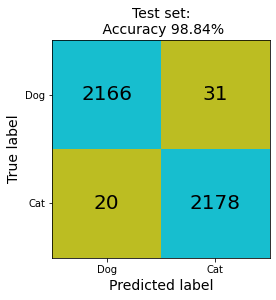

In [14]:
checkPointBest = f"checkpoint_{checkpoint}_best.pt"
validator = MyValidator(model, checkPointBest, dataSetTest, labelDic, "Test set")
validator.plotConfusionMatrix("Test set", f"ConfusionMatrixTestSetResults{checkpoint}")

### Validate the fine-tuned model with the validation data


Loading checkpoint: checkpoint_ColorImagesDenseNet201_best.pt
Found     42     true classified images in 61 images.
Found     19     false classified images in 61 images.

Confusion Matrix: [[ 0  0]
 [19 42]]
Found     0      images classified as trueDog    in 61 images.
Found     0      images classified as falseCat   in 61 images.
Found     19     images classified as falseDog   in 61 images.
Found     42     images classified as trueCat    in 61 images.


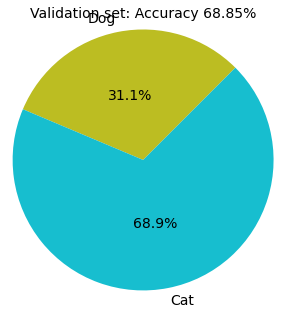

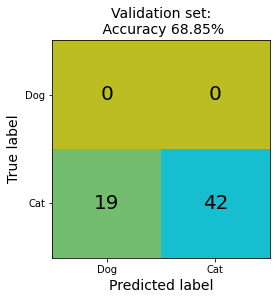

In [15]:
validator = MyValidator(model, checkPointBest, dataSetValidate, labelDic, "Validation set")
validator.plotPie("Validation set", f"PieChartValiSetResults{checkpoint}")
validator.plotConfusionMatrix("Validation set", f"ConfusionMatrixValiSetResults{checkpoint}")


Loading checkpoint: checkpoint_ColorImagesDenseNet201_best.pt
Found     50     true classified images in 61 images.
Found     11     false classified images in 61 images.

Confusion Matrix: [[ 0  0]
 [11 50]]
Found     0      images classified as trueDog    in 61 images.
Found     0      images classified as falseCat   in 61 images.
Found     11     images classified as falseDog   in 61 images.
Found     50     images classified as trueCat    in 61 images.


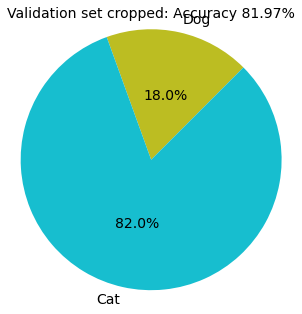

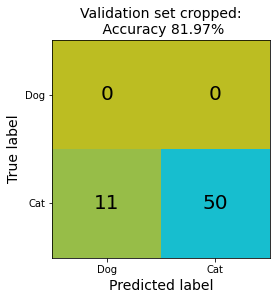

In [16]:
validator = MyValidator(model, checkPointBest, dataSetValidateCropped, labelDic, "Validation set cropped")
validator.plotPie("Validation set cropped", f"PieChartValiSetCroppedResults{checkpoint}")
validator.plotConfusionMatrix("Validation set cropped", f"ConfusionMatrixValiSetCroppedResults{checkpoint}")

### Plot some false and true classified images

Real: Cat -- Classified: Dog
Label: 1 -- Yhat: 0


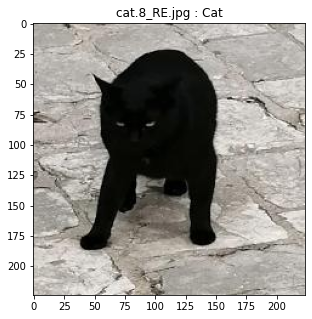

Real: Cat -- Classified: Dog
Label: 1 -- Yhat: 0


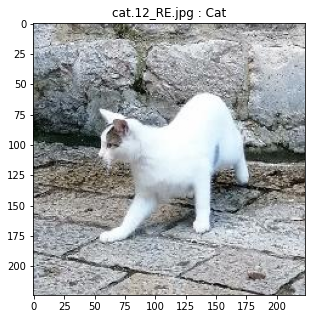

Real: Cat -- Classified: Dog
Label: 1 -- Yhat: 0


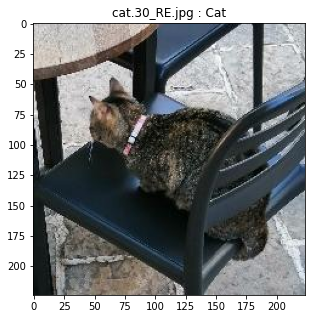

In [17]:
validator.plotClassifiedImages("False", 3)

Real: Cat -- Classified: Cat
Label: 1 -- Yhat: 1


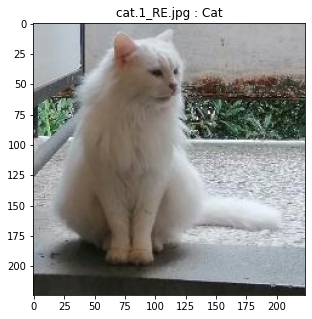

Real: Cat -- Classified: Cat
Label: 1 -- Yhat: 1


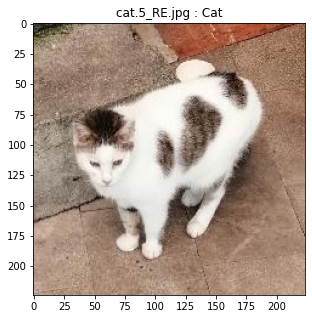

Real: Cat -- Classified: Cat
Label: 1 -- Yhat: 1


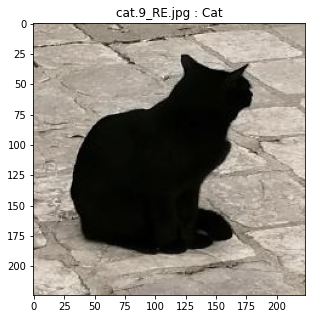

In [18]:
validator.plotClassifiedImages("True", 3)